In [1]:
# install dependencies
!pip install tweet-preprocessor==0.6.0
!pip install tensorflow==2.3.1
!pip install requests==2.25.0
# Tensorflow 2.3.1 requires numpy < 1.19.0
# !pip install numpy==1.19.0
!pip install pandas==1.1.4
!pip install tweet-preprocessor==0.6.0
!pip install tqdm==4.52.0

In [2]:
# define required libraries
import io
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preprocessor as p
import requests
import tensorflow as tf
from tqdm import tqdm

In [3]:
# prepare dataset
DATA_SET_URL = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
# extract zip file to data directory (generated if not exists)
DEST_DIR = './data'

r = requests.get(DATA_SET_URL, stream=True)
with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
    zf.extractall(DEST_DIR)

train_data_file_path = os.path.join(DEST_DIR, 'training.1600000.processed.noemoticon.csv')

assert(os.path.exists(train_data_file_path))

In [4]:
# read data
# note that we use polarity as label (0 = negative, 4 = positive)
# use only tweet and polarity columns
USED_COLS = ['tweet', 'polarity']
df = pd.read_csv(train_data_file_path, encoding='ISO-8859-1', header=None)
df.columns = ['polarity', 'tweet_id', 'date_of_tweet', 'query', 'user', 'tweet']
df = df[USED_COLS]

# relabel polarity from 4 to 1
df.loc[df['polarity'] == 4, 'polarity'] = 1
df.head()

,tweet,polarity
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [5]:
# preprocess tweets
# NOTE that p.clean should also be used in streaming pipeline
def preprocess_tweet(row):
    return p.clean(row)

# show progress
tqdm.pandas()
df['tweet'] = df['tweet'].progress_apply(preprocess_tweet)
df.head()

/home/josh9191/anaconda3/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1600000/1600000 [01:35<00:00, 16700.73it/s]


,tweet,polarity
0,"- Awww, that's a bummer. You shoulda got David...",0
1,is upset that he can't update his Facebook by ...,0
2,I dived many times for the ball. Managed to sa...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am ...",0


In [6]:
# train - val - test dataset split
# the code below shuffles dataframe and split dataset (6:2:2)
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(len(train_df), len(val_df), len(test_df))

960000 320000 320000


In [7]:
# we use RNN to train data
# create vocabulary and encode data
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_df['tweet'].values)

vocab = np.array(encoder.get_vocabulary())
print("[First 20 vocabularies]")
vocab[:20]

[First 20 vocabularies]


array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'for', 'in', 'of', 'im', 'on', 'me', 'so', 'have', 'that'],
      dtype='<U13')

In [8]:
# define sentiment analysis model
# TextVectorization -> Embedding -> Bidrectional -> Dense
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(5e-3),
              metrics=['accuracy'])

In [9]:
# fit model
# enable early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x=train_df['tweet'].values, y=train_df['polarity'].values,
                    batch_size=256, epochs=30,
                    callbacks=early_stopping_callback,
                    validation_data=(val_df['tweet'].values, val_df['polarity'].values),
                    validation_steps=30)

Epoch 1/30
3750/3750 [==============================] - 354s 94ms/step - loss: 0.6206 - accuracy: 0.7305 - val_loss: 0.6139 - val_accuracy: 0.7642
Epoch 2/30
3750/3750 [==============================] - 356s 95ms/step - loss: 0.6086 - accuracy: 0.7585 - val_loss: 0.6113 - val_accuracy: 0.7723
Epoch 3/30
3750/3750 [==============================] - 355s 95ms/step - loss: 0.6057 - accuracy: 0.7661 - val_loss: 0.6079 - val_accuracy: 0.7634
Epoch 4/30
3750/3750 [==============================] - 347s 93ms/step - loss: 0.6039 - accuracy: 0.7698 - val_loss: 0.6078 - val_accuracy: 0.7682
Epoch 5/30
3750/3750 [==============================] - 348s 93ms/step - loss: 0.6031 - accuracy: 0.7729 - val_loss: 0.6078 - val_accuracy: 0.7716
Epoch 6/30
3750/3750 [==============================] - 350s 93ms/step - loss: 0.6021 - accuracy: 0.7752 - val_loss: 0.6064 - val_accuracy: 0.7715
Epoch 7/30
3750/3750 [==============================] - 368s 98ms/step - loss: 0.6017 - accuracy: 0.7757 - val_loss: 0

In [10]:
test_loss, test_acc = model.evaluate(x=test_df['tweet'].values, y=test_df['polarity'].values)
print(f'Test Loss: {test_loss} / Test Accuracy: {test_acc}')

10000/10000 [==============================] - 105s 11ms/step - loss: 0.6041 - accuracy: 0.7736
Test Loss: 0.604108989238739 / Test Accuracy: 0.7735968828201294


(0.0, 0.6216015219688416)

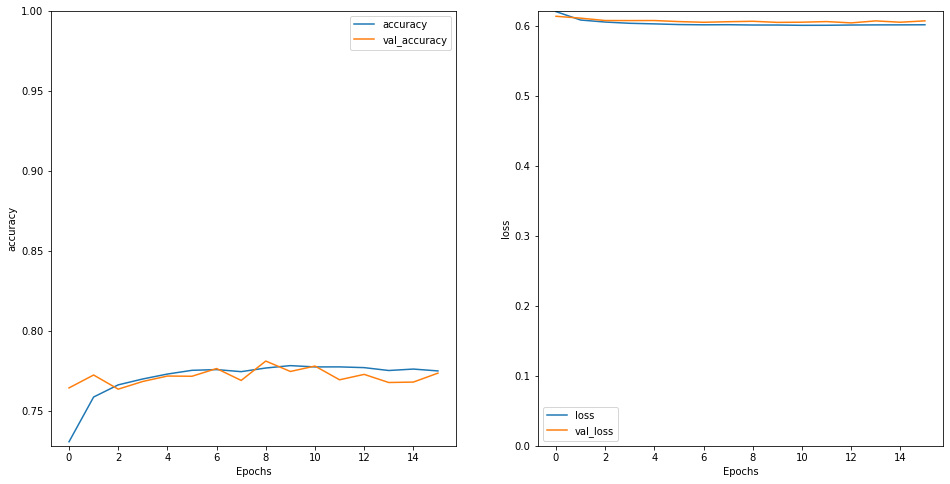

In [11]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [12]:
# save the model
model.save('./model', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/assets


In [13]:
model.predict(test_df['tweet'][:20].values)

array([[4.5368084e-01],
       [9.9963892e-01],
       [0.0000000e+00],
       [1.0000000e+00],
       [2.2855107e-34],
       [0.0000000e+00],
       [1.0000000e+00],
       [4.2382574e-01],
       [3.5636090e-32],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.0063497e-01],
       [5.6756590e-38],
       [0.0000000e+00],
       [3.6816210e-21],
       [0.0000000e+00],
       [2.3867410e-14],
       [1.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [14]:
test_df['tweet'][:20].values

array(['Erm, no but lease.. i have tomorrow though.. just to tie all the loose ends together! Then i shall be ready for Monday! xo',
       "is going to bed because he is not feeling well but is also thinking about auditions for 'So You Think You Can Dance '",
       'Omg i dnt want cleveland to win but aww i feel bad lebron. GO MAGIC!!!!!! -10',
       'Hmm for some reason I am obnoxiously motivated &amp; happy for a Monday? I like it',
       'All this talk about the iphone has me kind of jealous',
       'lie in tomo do i need say anymore!',
       "Interview planned with referee Eric Braamhaar for Monday afternoon I'll start writing down some questions, does anyone else has some?",
       'ready to give up on twitter, never get responses',
       "it's not some people are just to uptight/conservative. happy /20. Whish I was blazing...",
       "getting ready for Timmy's graduation party. Text the cell or stop on by.",
       'Up! and out. Cure for cube-itus? Looong lunch',
       "